# Conversation Chains and Memory with LCEL in LangChain
* Notebook by Adam Lang
* Date: 8/16/2024

# Overview
* In this notebook I will go over conversation chains and memory using the LCEL syntax method in LangChain.

# What is a Conversation
* A collection of historical messages between the user and the LLM.
* This includes: 1) Human Message, 2) AI Message
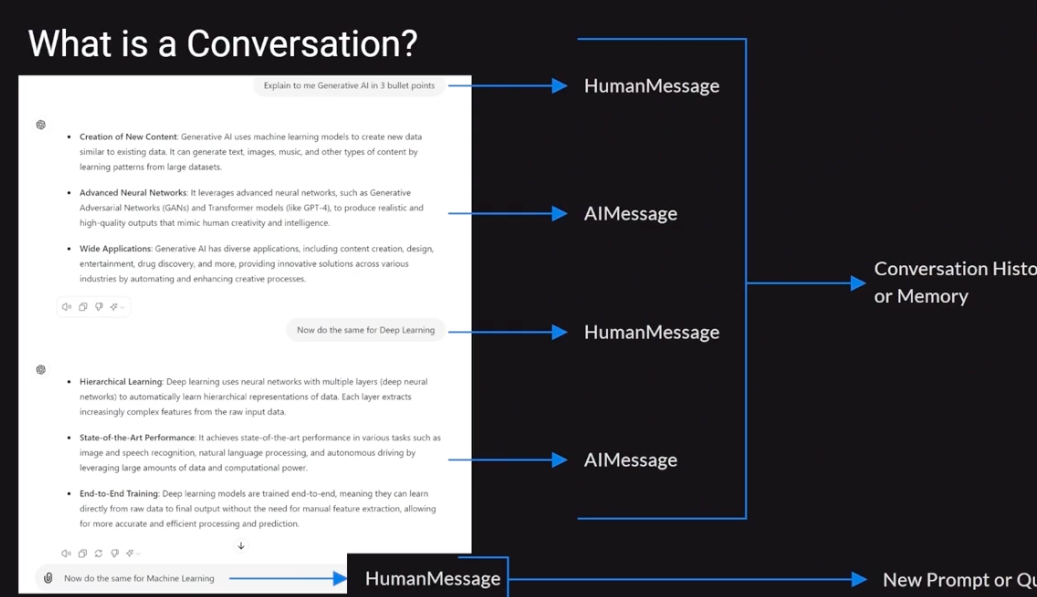

* Conversation History is also called "Memory" because it is stored information the LLM can rely on to answer new prompts or queries.

# Why do you need Conversational Memory?
* If you do not store message history the LLM has no context to build an answer or response from. In a way it is like performing "RAG" on your own prompts.
  * Conversations are stored in memory such as RAM or in a file or other source of your choice.
* Diagram of how this is different:
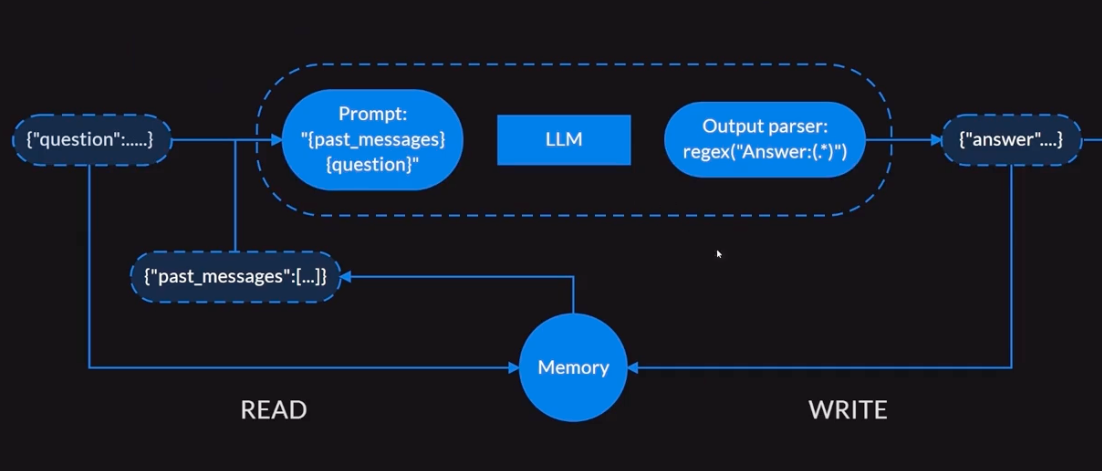

* Above we can see as you ask a question or query/prompt the messages are stored in memory (e.g. file, RAM, database).

## Built-in Memory Functions in LangChain
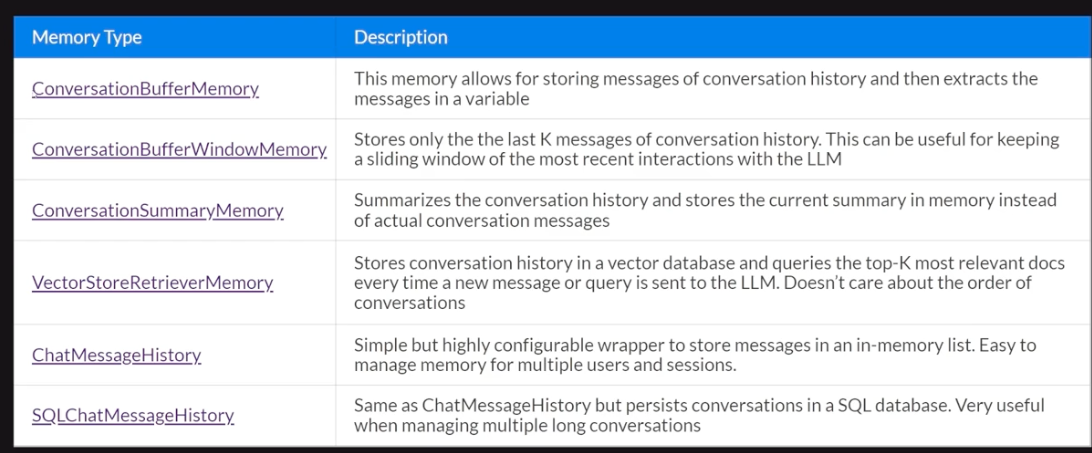

# Implementing Conversation Chains and Memory with LCEL in LangChain

## Library Dependencies

In [1]:
## langchain dependenies
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langchain-chroma==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.5/361.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31

## Enter OpenAI Key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI Key please: ')

Enter Open AI Key please: ··········


## Setup Environment Variables

In [3]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## LLM Connection

In [4]:
from langchain_openai import ChatOpenAI

# instantiate llm
chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

## What is the problem with "Simple LLM Chains"?
* They are not able to keep track of past conversation history.

In [5]:
## example of simple LLM chain
from langchain_core.prompts import ChatPromptTemplate

# prompt
prompt_txt = """{query}"""
prompt = ChatPromptTemplate.from_template(prompt_txt)

## also you can write this as: llm_chain = prompt | chatgpt
llm_chain = (
    prompt
      |
    chatgpt
)

In [7]:
## invoke llm response
response = llm_chain.invoke({'query': 'What are the first 3 colors of the rainbow?'})
print(response.content)

The first 3 colors of the rainbow are red, orange, and yellow.


In [8]:
## now ask another query without storing memory or conversation
response = llm_chain.invoke({'query': 'and the other 3?'})
print(response.content)

I'm sorry, I'm not sure what you are referring to. Can you please provide more context or clarify your question?


Summary:
* Aha! We can see that without storing the conversation/memory the LLM has no context on what we are talking about.

# Conversation Chains with LCEL in LangChain
* We will go over the following Memory Chains:
1. `ConversationBufferMemory`
2. `ConversationBufferWindowMemory`
3. `ConversationSummaryMemory`
4. `VectorStoreRetrieverMemory`
5. `ChatMessageHistory`
6. `SQLChatMessageHistory`

## ConversationBufferMemory Conversation Chains
* This is the most simple version of in-memory storage of historical conversation messages.
* This is basically a "buffer" for storing conversation memory.
* The problem or issue with this is that if you have really long conversation, you may exceed the max token limit of the context window the LLM allows.

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

## prompt
SYS_PROMPT = """Act as a very helpful assistant and give brief answers"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="history"), ## This holds all message history in memory
        ("human", "{query}"),
    ]
)

## memory instantiation
memory = ConversationBufferMemory(return_messages=True)

In [10]:
## get historical conversation messages from the memory
memory.load_memory_variables({})

{'history': []}

In [11]:
## create function which returns list of messages from memory
def get_memory_messages(query):
  return memory.load_memory_variables(query)['history']


#use function
get_memory_messages("What are the first 3 colors of the rainbow?")

[]

RunnableLambda allows us to call the chain at runtime and get the LCEL history.

In [14]:
## test function with runnable lambda with goes into the chain
## this will return the history but we also need to send our current query to the prompt
RunnableLambda(get_memory_messages).invoke({'query': 'What are the first 3 colors of the rainbow?'})

[]


RunnablePassthrough allows us to not only get the history but the current message at the same time.

In [16]:
## we use a runnable passthrough to pass our current query untouched
## along with the history messages to the next step in the chain
RunnablePassthrough.assign(
    history=RunnableLambda(get_memory_messages)
).invoke({'query': 'What are the first three colors of the rainbow?'})

{'query': 'What are the first three colors of the rainbow?', 'history': []}

In [17]:
## creating the conversation chain now
def get_memory_messages(query):
  return memory.load_memory_variables({})['history']


# conversation chain --> sends history + current query to prompt --> llm
conversation_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ) # sends current query (input by user at runtime) and history messages to next step
      |
    prompt # creates prompt using previous 2 variables
      |
    chatgpt # generates response using prompt from previous step
)


In [18]:
## now invoke query
query = {'query': 'What are the first three colors of the rainbow?'}
response = conversation_chain.invoke(query)
response

AIMessage(content='The first three colors of the rainbow are red, orange, and yellow.', response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 31, 'total_tokens': 46}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-7eb6744a-a957-4e84-b654-f81b8e493b69-0')

In [19]:
# print formatted response
print(response.content)

The first three colors of the rainbow are red, orange, and yellow.


In [20]:
## load memory variables
memory.save_context(query, {"output": response.content})

In [21]:
## load memory variables
memory.load_memory_variables({})

{'history': [HumanMessage(content='What are the first three colors of the rainbow?'),
  AIMessage(content='The first three colors of the rainbow are red, orange, and yellow.')]}

Asking a new query with memory stored

In [22]:
query = {'query': 'Explain machine learning in 2 bullet points'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) #remember to save current conversation in memory
print(response.content)

- Machine learning is a subset of artificial intelligence that involves developing algorithms and models that enable computers to learn from and make predictions or decisions based on data.
- It uses statistical techniques to allow machines to improve their performance on a specific task without being explicitly programmed.


In [23]:
query = {'query': 'Now do the same for NLP'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) #remember to save current conversation in memory
print(response.content)

- Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on enabling computers to understand, interpret, and generate human language.
- It involves developing algorithms and models that can analyze and process text data to extract meaning, sentiment, or intent.


In [24]:
query = {'query': 'What have we discussed so far in our conversation?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) #remember to save current conversation in memory
print(response.content)

We have discussed the colors of the rainbow, machine learning, and natural language processing (NLP).


In [26]:
## load memory variables
memory.load_memory_variables({})

{'history': [HumanMessage(content='What are the first three colors of the rainbow?'),
  AIMessage(content='The first three colors of the rainbow are red, orange, and yellow.'),
  HumanMessage(content='Explain machine learning in 2 bullet points'),
  AIMessage(content='- Machine learning is a subset of artificial intelligence that involves developing algorithms and models that enable computers to learn from and make predictions or decisions based on data.\n- It uses statistical techniques to allow machines to improve their performance on a specific task without being explicitly programmed.'),
  HumanMessage(content='Now do the same for NLP'),
  AIMessage(content='- Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on enabling computers to understand, interpret, and generate human language.\n- It involves developing algorithms and models that can analyze and process text data to extract meaning, sentiment, or intent.'),
  HumanMessage(content='What hav

Summary:
* Above we can see the full conversation memory.

## ConversationBufferWindowMemory Conversation Chains
* If you have a really long conversation, you might exceed the max token limit of the context window allowed for the LLM when using ConversationBufferMemory.
* This is where the **ConversationBufferWindowMemory** helps in just storing the last K conversations (one conversation piece is one user message and the corresponding AI message from the LLM) and thus helps you manage token limits and costs.

In [29]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferWindowMemory ## this is new
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

# system prompt
SYS_PROMPT = """Act as a helpful assistant and give brief answers."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{query}"),
    ]
)

# stores last 2 sets of human-AI conversations --> usually a K of 20 to 30 works for most LLMs
memory = ConversationBufferWindowMemory(return_messages=True, k=2) ## k=2 - stores the last 2 converations (4 messages)

# creating our conversation chain now
def get_memory_messages(query):
    return memory.load_memory_variables(query)['history']

conversation_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ) # sends current query (input by user at runtime) and history messages to next step
      |
    prompt # creates prompt using the previous two variables
      |
    chatgpt # generates response using the prompt from previous step
)

In [30]:
query = {'query': 'What are the first three colors of the rainbow?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

The first three colors of the rainbow are red, orange, and yellow.


In [31]:
query = {'query': 'and what are the other colors?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

The other colors of the rainbow are green, blue, indigo, and violet.


In [32]:
query = {'query': 'Explain what machine learning is in 2 bullet points'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- Machine learning is a subset of artificial intelligence that involves developing algorithms and statistical models to enable computers to learn from and make predictions or decisions based on data.
- It allows machines to improve their performance on a task over time without being explicitly programmed, by identifying patterns and relationships in data.


In [33]:
query = {'query': 'Now do the same for NLP'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on enabling computers to understand, interpret, and generate human language.
- It involves developing algorithms and models to process and analyze text data, enabling tasks such as language translation, sentiment analysis, and text generation.


In [35]:
## load memory variables
memory.load_memory_variables({})

{'history': [HumanMessage(content='Explain what machine learning is in 2 bullet points'),
  AIMessage(content='- Machine learning is a subset of artificial intelligence that involves developing algorithms and statistical models to enable computers to learn from and make predictions or decisions based on data.\n- It allows machines to improve their performance on a task over time without being explicitly programmed, by identifying patterns and relationships in data.'),
  HumanMessage(content='Now do the same for NLP'),
  AIMessage(content='- Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on enabling computers to understand, interpret, and generate human language.\n- It involves developing algorithms and models to process and analyze text data, enabling tasks such as language translation, sentiment analysis, and text generation.')]}

In [36]:
query = {'query': 'What have we discussed so far?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

We have discussed machine learning and natural language processing (NLP) in brief, highlighting their key concepts and applications.


In [37]:
# load memory variables
memory.load_memory_variables({})

{'history': [HumanMessage(content='Now do the same for NLP'),
  AIMessage(content='- Natural Language Processing (NLP) is a branch of artificial intelligence that focuses on enabling computers to understand, interpret, and generate human language.\n- It involves developing algorithms and models to process and analyze text data, enabling tasks such as language translation, sentiment analysis, and text generation.'),
  HumanMessage(content='What have we discussed so far?'),
  AIMessage(content='We have discussed machine learning and natural language processing (NLP) in brief, highlighting their key concepts and applications.')]}

Summary:
* We can see that because we set K=2 we are only storing the last 2 conversations (4 messages).

## ConversationSummaryMemory Converation Chains
If you have a really long conversation or a lot of messages, you might exceed the max token limit of the context window allowed for the LLM when using ConversationBufferMemory

**ConversationSummaryMemory creates a summary of the conversation history over time. This can be useful for condensing information from the conversation messages over time.**
  * This memory is most useful for longer conversations, where keeping the past message history in the prompt verbatim would take up too many tokens.

In [38]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationSummaryMemory
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

SYS_PROMPT = """Act as a helpful assistant and give brief answers"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{query}"),
    ]
)
# send messages to chatgpt llm
memory = ConversationSummaryMemory(return_messages=True, llm=chatgpt) ## this is the only difference from above
# creating our conversation chain now
def get_memory_messages(query):
    return memory.load_memory_variables(query)['history']

conversation_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ) # sends current query (input by user at runtime) and history messages as a summary to next step
      |
    prompt # creates prompt using the previous two variables
      |
    chatgpt # generates response using the prompt from previous step
)

In [39]:
query = {'query': 'Explain what machine learning is in 2 bullet points'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

- Machine learning is a branch of artificial intelligence that involves developing algorithms and statistical models to enable computers to learn from and make predictions or decisions based on data.
- It allows machines to improve their performance on a task over time without being explicitly programmed, by recognizing patterns and making decisions based on the data they are exposed to.


In [40]:
query = {'query': 'Now do the same for NLP'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

1. NLP (Natural Language Processing) involves developing algorithms and models that enable computers to understand, interpret, and generate human language.
2. NLP allows machines to analyze and process large amounts of text data, extract meaningful information, and perform tasks such as sentiment analysis, language translation, and text summarization.


In [41]:
## load memory variables
memory.load_memory_variables({})

{'history': [SystemMessage(content='The human asks the AI to explain what machine learning is in 2 bullet points. The AI explains that machine learning involves developing algorithms and statistical models to enable computers to learn from data and make predictions, as well as improve their performance over time. The human then asks the AI to do the same for NLP. The AI explains that NLP involves developing algorithms and models that enable computers to understand, interpret, and generate human language, allowing machines to analyze text data and perform tasks like sentiment analysis and language translation.')]}

We can see above we get a summary of our full conversation rather than each message by itself (k=2).

In [42]:
query = {'query': 'What have we discussed so far?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

We have discussed machine learning and natural language processing (NLP) in brief points.


## VectorStoreRetrieverMemory Conversation Chains

VectorStoreRetrieverMemory stores historical conversation messages in a vector store or vector database and queries the top-K most "relevant" history messages every time it is called.
  * This differs from most of the other Memory classes in that it **doesn't explicitly track the order of interactions** but retrieves history based on **embedding or cosine similarity** to the current question or prompt.

In this case, the "docs" are previous conversation snippets. This can be useful to refer to relevant pieces of information that the AI was told earlier in the conversation.

### Connect to the Open AI Embedding Models
* LangChain allows us to access Open AI embedding models which include the newest models: a smaller and highly efficient `text-embedding-3-small` model, and a larger and more powerful `text-embedding-3-large model`.

In [43]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

### Create a Vector Database to store conversation history
* We will use Chroma Vector DB.

In [44]:
from langchain_chroma import Chroma

# create empty vector store
chroma_db = Chroma(collection_name='history_db',
                   embedding_function=openai_embed_model)

In [45]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import VectorStoreRetrieverMemory
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

SYS_PROMPT = """Act as a helpful assistant and give brief answers"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{query}"),
    ]
)

# load 2 most similar conversation messages from vector db history for each new message or prompt
# this uses cosine embedding similarity to load the top 2 similar messages to the input prompt or query
retriever = chroma_db.as_retriever(search_type="similarity",
                                   search_kwargs={"k": 2})
memory = VectorStoreRetrieverMemory(retriever=retriever, return_messages=True)

# creating our conversation chain now
def get_memory_messages(query):
    return [memory.load_memory_variables(query)['history']] ## retrieve list of historical messages

conversation_chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(get_memory_messages)
    ) # sends current query (input by user at runtime) and history messages to next step
      |
    prompt # creates prompt using the previous two variables
      |
    chatgpt # generates response using the prompt from previous step
)

In [46]:
query = {'query': 'Tell me about machine learning'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

Machine learning is a subset of artificial intelligence that involves developing algorithms and statistical models that enable computers to learn from and make predictions or decisions based on data without being explicitly programmed. It is used in a wide range of applications, such as image and speech recognition, medical diagnosis, recommendation systems, and autonomous vehicles.


In [47]:
query = {'query': 'What about NLP'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

NLP, or natural language processing, is a branch of artificial intelligence that focuses on the interaction between computers and humans using natural language. It involves tasks such as text analysis, language translation, sentiment analysis, and chatbots. NLP enables computers to understand, interpret, and generate human language, making it a crucial technology for applications like virtual assistants, language translation services, and text analysis tools.


In [48]:
query = {'query': 'Tell me about the fastest animal in the world in 2 lines'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

The fastest animal in the world is the peregrine falcon, capable of reaching speeds over 240 miles per hour while diving to catch prey. Its incredible speed and agility make it one of the most efficient hunters in the animal kingdom.


In [49]:
query = {'query': 'What about the cheetah?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

The cheetah is the fastest land animal, capable of reaching speeds up to 60-70 miles per hour in short bursts. Its acceleration and agility make it an impressive predator in the wild.


Now for a new query around deep learning even if the most recent conversation messages have been about animals, it uses the vector databases to load the last 2 historical conversations which are closest to the current question in terms of semantic similarity

In [52]:
print(memory.load_memory_variables({'query': 'What about Deep Learning?'})['history'])

query: What about deep learning?
output: Deep learning is a subset of machine learning that uses artificial neural networks to model and solve complex problems. It involves training deep neural networks with multiple layers to learn representations of data at different levels of abstraction. Deep learning has been particularly successful in tasks such as image and speech recognition, natural language processing, and autonomous driving.
query: Tell me about machine learning
output: Machine learning is a subset of artificial intelligence that involves developing algorithms and statistical models that enable computers to learn from and make predictions or decisions based on data without being explicitly programmed. It is used in a wide range of applications, such as image and speech recognition, medical diagnosis, recommendation systems, and autonomous vehicles.


Summary:
* We were able to retrieve the most semantically similar conversation messages.

In [51]:
query = {'query': 'What about deep learning?'}
response = conversation_chain.invoke(query)
memory.save_context(query, {"output": response.content}) # remember to save your current conversation in memory
print(response.content)

Deep learning is a subset of machine learning that uses artificial neural networks to model and solve complex problems. It involves training deep neural networks with multiple layers to learn representations of data at different levels of abstraction. Deep learning has been particularly successful in tasks such as image and speech recognition, natural language processing, and autonomous driving.


Summary:
* We saw with the vector store method above we were able to retrieve the top k results based on embedding or cosine similarity.

## Multi-user Conversation Chains with ChatMessageHistory
* **This is commonly used for real world chatbots.**
* **The idea is to store each individual users history.**
* The concept of ChatHistory refers to a class in LangChain which can be used to wrap an arbitrary chain.
* This ChatHistory will keep track of inputs and outputs of the underlying chain, and append them as messages to a message database.
   * Future interactions will then load those messages and pass them into the chain as part of the input.

* What is great about ChatMessageHistory is that we can store separate conversation histories per user or session which is often the need for real-world chatbots which will be accessed by many users at the same time.

* We use a get_session_history function which is expected to take in a session_id and return a Message History object.
* Everything is stored in memory.
* This session_id is used to distinguish between separate conversations, and should be passed in as part of the config when calling the new chain

In [53]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# used to retrieve conversation history from memory
# based on a specific user or session ID
## empty dict to store history of user conversations
history_store = {}
def get_session_history(session_id):
    if session_id not in history_store:
        history_store[session_id] = ChatMessageHistory()
    return history_store[session_id]

# prompt to load in history and current input from the user
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "Act as a helpful AI Assistant"),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{human_input}"),
    ]
)

# create a basic LLM Chain -- this is not a conversational history chain
llm_chain = (prompt_template
                |
             chatgpt)

# create a conversation chain which can load memory based on specific user or session id
conv_chain = RunnableWithMessageHistory(
    llm_chain,
    get_session_history,
    input_messages_key="human_input",
    history_messages_key="history",
)

# create a utility function to take in current user input prompt and their session ID
# streams result live back to the user from the LLM -- stream function
def chat_with_llm(prompt: str, session_id: str):
    for chunk in conv_chain.stream({"human_input": prompt},
                                   {'configurable': { 'session_id': session_id}}):
        print(chunk.content, end="")

Test conversation chain for user 1

In [55]:
user_id = 'bob123'
prompt = "Hi I am Bob, can you explain machine learning in 3 bullet points?"
chat_with_llm(prompt, user_id)

- Machine learning is a subset of artificial intelligence that involves the development of algorithms and statistical models that enable computers to learn from and make predictions or decisions based on data.
- In machine learning, algorithms are trained on data to identify patterns and relationships, allowing the system to improve its performance over time without being explicitly programmed.
- Common machine learning techniques include supervised learning, unsupervised learning, and reinforcement learning, each suited for different types of tasks such as classification, clustering, and sequential decision-making.

In [56]:
prompt = "Now do the same for NLP"
chat_with_llm(prompt, user_id)

- NLP, or natural language processing, is a branch of artificial intelligence that focuses on the interaction between computers and human language, enabling machines to understand, interpret, and generate human language.
- NLP techniques involve processing and analyzing large amounts of text data to extract meaning, sentiment, and context, allowing for tasks such as text classification, sentiment analysis, and language translation.
- NLP applications range from virtual assistants and chatbots to language translation services, sentiment analysis tools, and information retrieval systems, enhancing human-computer interaction and communication.

In [57]:
prompt = "Discuss briefly what we have discussed so far in bullet points."
chat_with_llm(prompt, user_id)

- AI, or artificial intelligence, simulates human intelligence processes in machines, enabling tasks like learning, reasoning, and problem-solving.
- Machine learning is a subset of AI that involves developing algorithms to learn from data and make predictions or decisions without being explicitly programmed.
- NLP, or natural language processing, is an AI branch focused on enabling computers to understand, interpret, and generate human language, enhancing communication and interaction between humans and machines.

Test conversation for user 2
* User accessing chain/chat bot at same time.

In [62]:
user_id = 'james007'
prompt = 'Hi can you explain what LLM is in 2 bullet points?'
chat_with_llm(prompt, user_id)

- LLM stands for Large Language Model, which refers to a type of natural language processing model that is trained on a large amount of text data to understand and generate human-like text.
- LLMs are designed to capture the complexities of language and context, allowing them to perform tasks such as text generation, language translation, and sentiment analysis with high accuracy.

In [75]:
prompt = "Acutally I meant in the context of deep learning?"
chat_with_llm(prompt, user_id)

I apologize for the confusion. Here are the topics we have discussed in the context of deep learning:

- Neural networks: a computational model inspired by the human brain that is used in deep learning for tasks like image recognition and natural language processing
- Convolutional neural networks (CNNs): a type of neural network commonly used for image recognition tasks due to their ability to capture spatial hierarchies in data
- Recurrent neural networks (RNNs): a type of neural network designed to handle sequential data, making them suitable for tasks like speech recognition and language modeling
- Generative adversarial networks (GANs): a type of neural network architecture that consists of two networks, a generator and a discriminator, used for generating new data samples
- Transfer learning: a technique in deep learning where a pre-trained model is used as a starting point for a new task, allowing for faster training and better performance on limited data
- Natural language proc

In [76]:
prompt = "Please summarize briefly what we have discussed so far"
chat_with_llm(prompt, user_id)

Certainly! We have discussed various topics related to deep learning, including neural networks, convolutional neural networks (CNNs), recurrent neural networks (RNNs), generative adversarial networks (GANs), transfer learning, and natural language processing (NLP). These concepts are fundamental in the field of artificial intelligence and are used for tasks such as image recognition, speech recognition, language modeling, and data generation.

## Multi-user Window-based Conversation Chains with persistence - SQLChatMessageHistory
* **Here you would store message history in a SQL or relational database.**

* With `SQLChatMessageHistory` we can store separate conversation histories per user or session which is often the need for real-world chatbots which will be accessed by many users at the same time.
  * Instead of in-memory we can store it in a SQL database which can be used to store a lot of conversations.

* We use a `get_session_history` function which is expected to take in a `session_id` and return a Message History object. Everything is stored in a SQL database.
  * This `session_id` is used to distinguish between separate conversations, and should be passed in as part of the config when calling the new chain.

* We also use a `memory_buffer_window` function to only use the top-K last historical conversations before sending it to the LLM, basically our own implementation of `ConversationBufferWindowMemory`

In [64]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove all conversation histories
!rm memory.db

rm: cannot remove 'memory.db': No such file or directory


In [65]:
from langchain_community.chat_message_histories import SQLChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough

# used to retrieve conversation history from database
# based on a specific user or session ID
def get_session_history_db(session_id):
    return SQLChatMessageHistory(session_id, "sqlite:///memory.db") ##sqlite database

# prompt to load in history and current input from the user
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "Act as a helpful AI Assistant"),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{human_input}"),
    ]
)

# create a memory buffer window function to return the last K conversations
def memory_buffer_window(messages, k=2):
    return messages[-(k+1):]

# create a basic LLM Chain which only sends the last K conversations per user
llm_chain = (
    RunnablePassthrough.assign(history=lambda x: memory_buffer_window(x["history"]))
      |
    prompt_template
      |
    chatgpt
)

In [66]:
# create a conversation chain which can load memory based on specific user or session id
conv_chain = RunnableWithMessageHistory(
    llm_chain,
    get_session_history_db,
    input_messages_key="human_input",
    history_messages_key="history",
)

# create a utility function to take in current user input prompt and their session ID
# streams result live back to the user from the LLM
def chat_with_llm(prompt: str, session_id: str):
    for chunk in conv_chain.stream({"human_input": prompt},
                                   {'configurable': { 'session_id': session_id}}):
        print(chunk.content, end="")

Test conversation chain for user 1

In [67]:
user_id = 'bill001'
prompt = "Hi can you tell me what the fastest car in the world is?"
chat_with_llm(prompt, user_id)

As of now, the fastest car in the world is the SSC Tuatara. It set a new top speed record of 331.15 mph (532.93 km/h) in October 2020.

In [68]:
prompt = "What about the slowest car?"
chat_with_llm(prompt, user_id)

The slowest car in the world is often considered to be the Peel P50, a microcar that was produced in the 1960s. It has a top speed of around 35 mph (56 km/h) and is known for its compact size and unique design.

In [69]:
prompt = "What about the most expensive car?"
chat_with_llm(prompt, user_id)

As of now, the most expensive car in the world is the Bugatti La Voiture Noire. It was sold for a reported price of around $18.68 million. The Bugatti La Voiture Noire is a one-of-a-kind luxury sports car that pays homage to the classic Bugatti Type 57SC Atlantic.

In [70]:
prompt = "What topics have we discussed so far, briefly in bullet points"
chat_with_llm(prompt, user_id)

- Slowest car in the world: Peel P50
- Most expensive car in the world: Bugatti La Voiture Noire

Test Conversation chain for user 2

In [71]:
user_id = 'Drake005'
prompt = "Explain what classical music is in 3 bullet points to a 5th grader."
chat_with_llm(prompt, user_id)

- Classical music is a type of music that was composed a long time ago by famous musicians like Beethoven and Mozart.
- It is usually played by orchestras, which are groups of musicians playing different instruments like violins, flutes, and trumpets.
- Classical music is known for its beautiful melodies and complex harmonies that can make you feel different emotions when you listen to it.

In [72]:
prompt = "Now do the same for Grunge"
chat_with_llm(prompt, user_id)

- Grunge is a type of rock music that became popular in the 1990s, with bands like Nirvana and Pearl Jam leading the way.
- It has a raw and gritty sound, with loud guitars and emotional lyrics that often talk about feelings of anger, frustration, and disillusionment.
- Grunge music is known for its rebellious and anti-establishment attitude, and it was a big part of the alternative music scene in the 90s.

In [73]:
prompt = "Now do the same for Rap"
chat_with_llm(prompt, user_id)

- Rap is a genre of music that originated in the United States in the 1970s, with artists like Grandmaster Flash and The Sugarhill Gang pioneering the genre.
- It is characterized by rhythmic spoken or chanted lyrics over a musical backing, often with a strong beat and catchy hooks.
- Rap music often addresses social and political issues, as well as personal experiences and storytelling.
- It has evolved over the years to include different sub-genres like gangsta rap, conscious rap, and mumble rap, with artists like Tupac Shakur, Jay-Z, and Kendrick Lamar becoming iconic figures in the genre.

In [74]:
prompt = "So what topics have we discussed so far, please list in bullet points."
chat_with_llm(prompt, user_id)

- Grunge music: a type of rock music popular in the 1990s with a raw and gritty sound
- Rap music: a genre originating in the US in the 1970s, characterized by rhythmic spoken or chanted lyrics
- Grunge music features loud guitars and emotional lyrics about anger and disillusionment
- Rap music addresses social and political issues, personal experiences, and storytelling

# Summary
* We saw different ways to build chatbots and store the conversation messages in memory, in a vector database and in a SQL relational database.